In [2]:
%matplotlib inline

## Wavelength solution with RASCAL (v0.3.10)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from scipy.signal import find_peaks
from rascal.calibrator import Calibrator
from rascal.util import refine_peaks

/home/ahrer/.conda/envs/Tiberius/lib/python3.8/site-packages/rascal/calibrator.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import peakutils
from scipy import stats,optimize,interpolate
import pickle
import reduction_utils.wavelength_calibration as wc

In [53]:
def rascal_find_wvl_solution(spectrum, wvl_min, wvl_max):
    peaks, _ = find_peaks(spectrum, prominence=150, distance=25, threshold=None)
    print(peaks)
    print(len(peaks))
    plt.figure()
    plt.plot(spectrum)
    plt.vlines(peaks,
              spectrum[peaks.astype('int')],
              spectrum.max(),
              colors='C1')
    
    peaks_refined=refine_peaks(spectrum, peaks, window_width=4)
    plt.figure()
    plt.plot(spectrum)
    plt.vlines(peaks_refined,0,1.05*spectrum.max(),colors='C1')
    
    # Set up the Calibrator object
    c = Calibrator(peaks_refined,
                   spectrum)
    c.set_calibrator_properties(num_pix=len(spectrum),
                                plotting_library='matplotlib',
                                log_level='info')
    
    c.plot_arc()

    c.set_hough_properties(
                       min_wavelength=wvl_min,
                       max_wavelength=wvl_max,
                       range_tolerance=500.,
                       linearity_tolerance=50)

    c.set_ransac_properties(sample_size=5,
                        top_n_candidate=8)
    
    c.add_atlas(elements=["He","Ar"])

    c.do_hough_transform()

    # Solve for the wavelength calibration
    best_polyfit_coefficient, match_peaks, match_atlas, rms, residual, peak_utilisation, atlas_utilisation = c.fit(max_tries=200,
                                                                  fit_deg=7, progress=True)

    print("RMS: {}".format(rms))
    print("Stdev error: {} A".format(np.abs(residual).std()))
    print("Peaks utilisation rate: {}%".format(peak_utilisation*100))

    c.plot_fit(best_polyfit_coefficient)

    print(best_polyfit_coefficient)
    best_polyfit_coefficient = np.array(best_polyfit_coefficient)
    
    print(c.polyval(best_polyfit_coefficient,0))
    wvl = c.polyval(np.arange(0,row_max-row_min),best_polyfit_coefficient)
    return wvl

In [6]:
parent_direc = '../reduction_21/'

# Load in stellar spectra
s1 = pickle.load(open(parent_direc+'pickled_objects/star1_flux_cleaned.pickle','rb'))
s2 = pickle.load(open(parent_direc+'pickled_objects/star2_flux_cleaned.pickle','rb'))

# Load in x positions of traces, so that we can extract the arc spectra at the same locations as the stars
trace1 = pickle.load(open(parent_direc+'pickled_objects/x_positions_1.pickle','rb'))
trace2 = pickle.load(open(parent_direc+'pickled_objects/x_positions_2.pickle','rb'))


In [9]:
# load in the frame

arc_fits = fits.open('../EFOSC_spec_HeAr227_0003.fits')
#arc_fits = fits.open('/storage/astro2/phrgmk/Data/EFOSC/HATS-46/EFOSC.2017-08-17T11:54:57.239.fits')

#arc_fits = fits.open('/storage/astro2/phrgmk/Data/EFOSC/WASP-49/EFOSC.2021-02-18T09:22:32.372.fits')

# extract data from relevant fits extension
arc = arc_fits[0].data
nframes = len(s1)
row_min = 200
row_max = 1000
rows = np.arange(row_min,row_max)
nrows = len(s1[0])
print(arc)
arc = arc.astype(float)
print(arc.shape)

[[ 70 246 229 ...  66  89   0]
 [200 203 221 ...  73  78  66]
 [204 213 217 ...  72  63  65]
 ...
 [191 193 181 ...  80  89  74]
 [195 166 191 ...  84  73  77]
 [183 187 170 ...  68  79  91]]
(1030, 1030)


In [15]:
slice_arc_1 = []

slice_arc_2 = []


for i, r in enumerate(rows):
    row = arc[r]
    slice_arc_1.append(row[int(trace1[nframes//2][i])])
    slice_arc_2.append(row[int(trace2[nframes//2][i])])
 
slice_arc_1 = np.array(slice_arc_1)
slice_arc_2 = np.array(slice_arc_2)

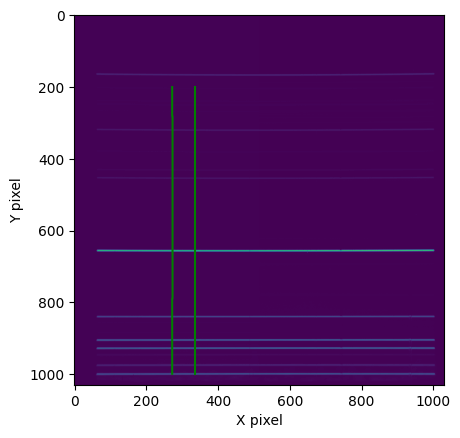

In [16]:
plt.figure()
plt.imshow(arc)
plt.plot(trace1[nframes//2],rows,color='g')
plt.plot(trace2[nframes//2],rows,color='g')
plt.ylabel('Y pixel')
plt.xlabel('X pixel')
plt.show()

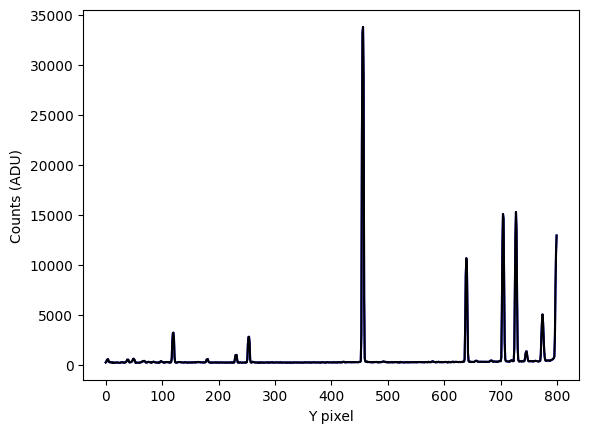

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [17]:
plt.figure()
plt.plot(slice_arc_1,color='b')
plt.plot(slice_arc_1, color='k')
plt.xlabel('Y pixel')
plt.ylabel('Counts (ADU)')
plt.show()
spectrum_1 = slice_arc_1
spectrum_2 = slice_arc_2
#spectrum_1 = np.median(arc.T, axis=0)

print(type(spectrum_2),type(spectrum_1))
#print(np.mean(abs(spectrum_1-spectrum_2)))

[Thu, 14 Dec 2023 10:32:41] INFO [calibrator.py:930] num_pix is set to 800.
[Thu, 14 Dec 2023 10:32:41] INFO [calibrator.py:942] pixel_list is set to None.
[Thu, 14 Dec 2023 10:32:41] INFO [calibrator.py:971] Plotting with matplotlib.


[  4  49 120 181 254 456 639 727 774]
9


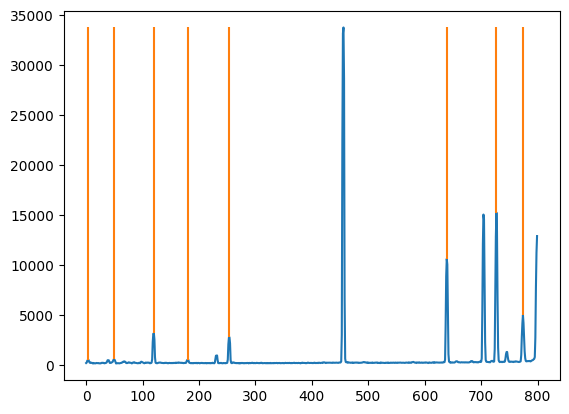

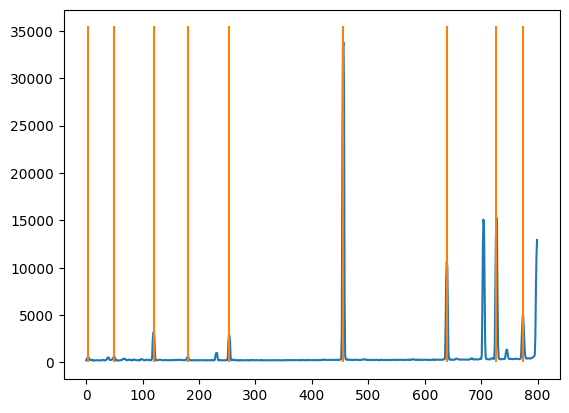

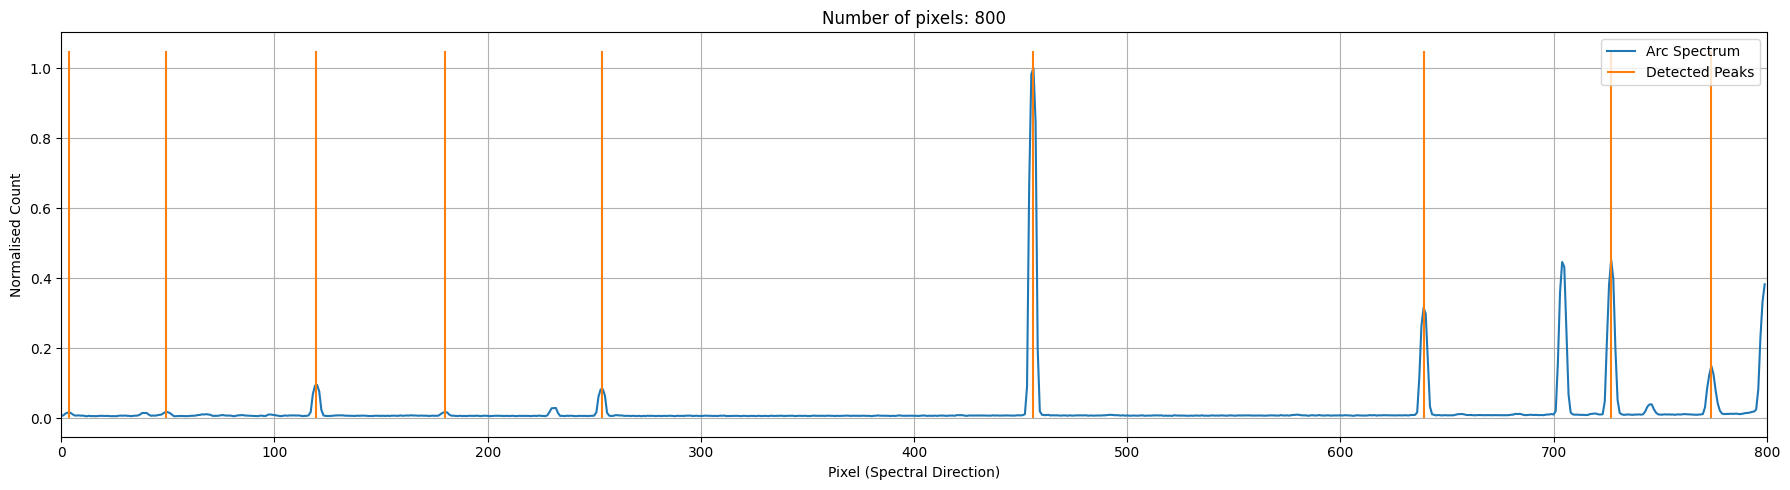

[Thu, 14 Dec 2023 10:32:41] WARNING [calibrator.py:1299] Using add_atlas is now deprecated. Please use the new Atlas class.


  0%|          | 0/200 [00:00<?, ?it/s]

[Thu, 14 Dec 2023 10:32:54] INFO [calibrator.py:750] Found: 9
[Thu, 14 Dec 2023 10:32:54] INFO [plotting.py:805] Peak at: 3013.6735753723474 A
[Thu, 14 Dec 2023 10:32:54] INFO [plotting.py:809] - matched to 3013.6735753723474 A
[Thu, 14 Dec 2023 10:32:54] INFO [plotting.py:805] Peak at: 3819.54772059857 A
[Thu, 14 Dec 2023 10:32:54] INFO [plotting.py:809] - matched to 3819.54772059857 A
[Thu, 14 Dec 2023 10:32:54] INFO [plotting.py:805] Peak at: 4198.2519257848535 A
[Thu, 14 Dec 2023 10:32:54] INFO [plotting.py:809] - matched to 4198.2519257848535 A
[Thu, 14 Dec 2023 10:32:54] INFO [plotting.py:805] Peak at: 4333.493421531717 A
[Thu, 14 Dec 2023 10:32:54] INFO [plotting.py:809] - matched to 4333.493421531717 A
[Thu, 14 Dec 2023 10:32:54] INFO [plotting.py:805] Peak at: 4702.243698133409 A
[Thu, 14 Dec 2023 10:32:54] INFO [plotting.py:809] - matched to 4702.243698133409 A
[Thu, 14 Dec 2023 10:32:54] INFO [plotting.py:805] Peak at: 6678.049494311709 A
[Thu, 14 Dec 2023 10:32:54] INFO [pl

RMS: 0.11961925077162376
Stdev error: 0.08678497131201393 A
Peaks utilisation rate: 100.0%


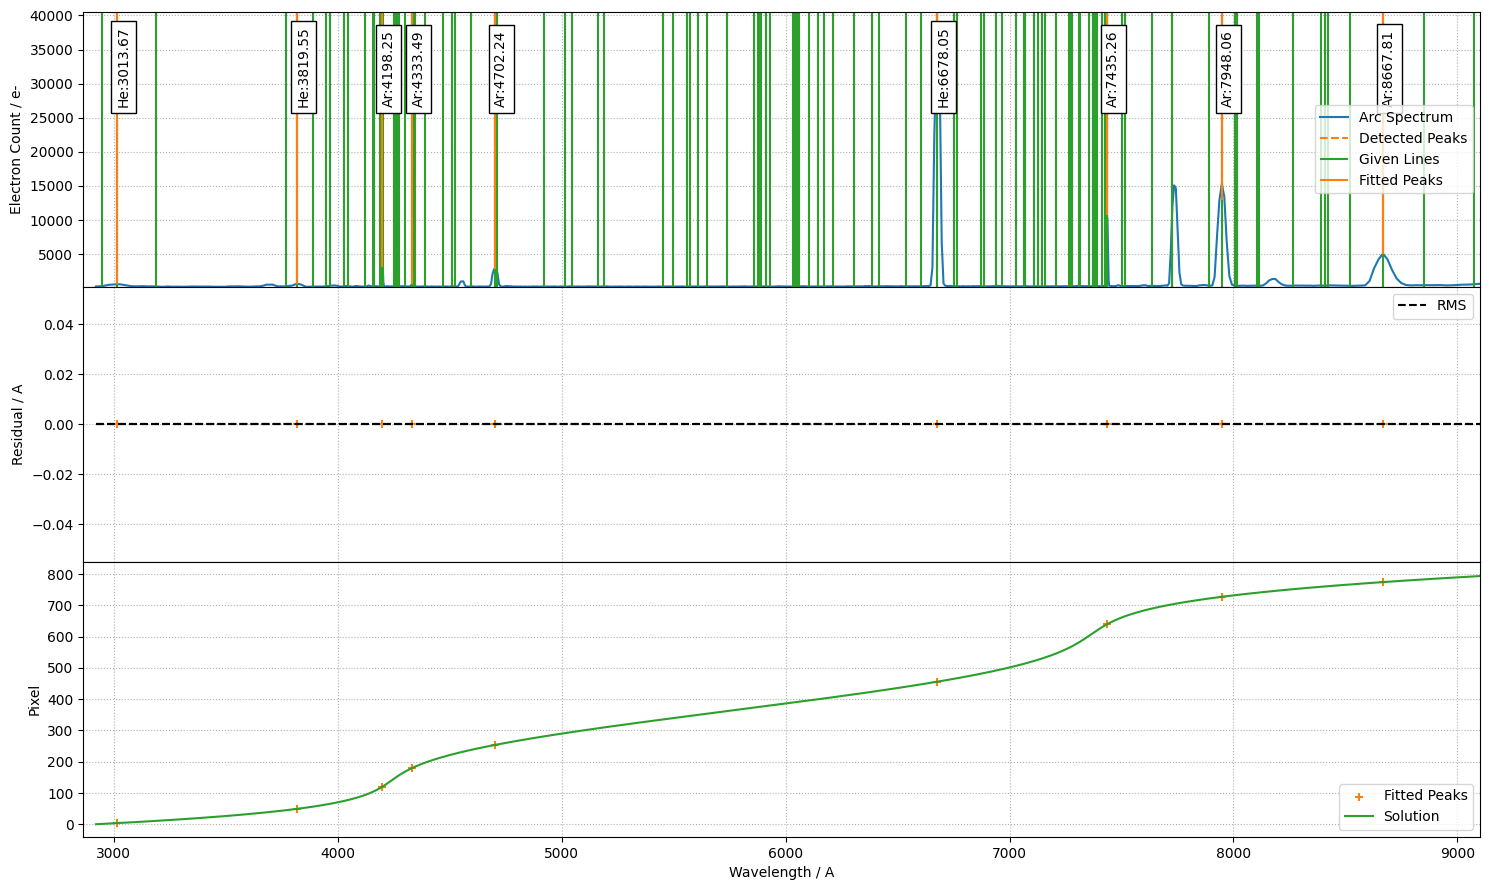

[Thu, 14 Dec 2023 10:32:55] INFO [calibrator.py:930] num_pix is set to 800.
[Thu, 14 Dec 2023 10:32:55] INFO [calibrator.py:942] pixel_list is set to None.
[Thu, 14 Dec 2023 10:32:55] INFO [calibrator.py:971] Plotting with matplotlib.


[ 2.91986224e+03  2.75654792e+01 -2.29869188e-01  9.05421944e-04
 -1.45416634e-06  7.17905396e-10  3.37906103e-13 -2.87797161e-16]
[0. 0. 0. 0. 0. 0. 0. 0.]
[  4  49 119 180 253 456 639 727 774]
9


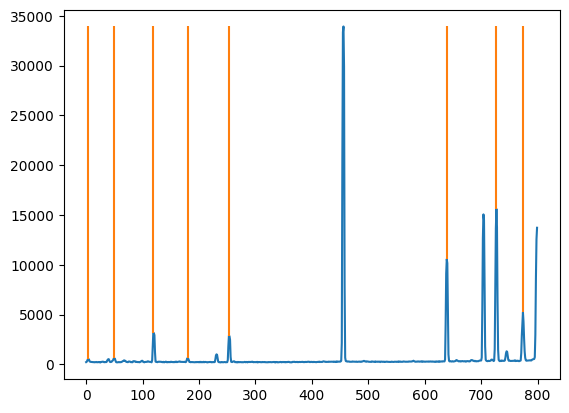

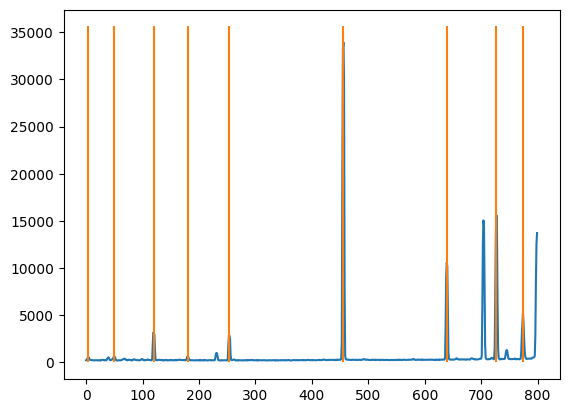

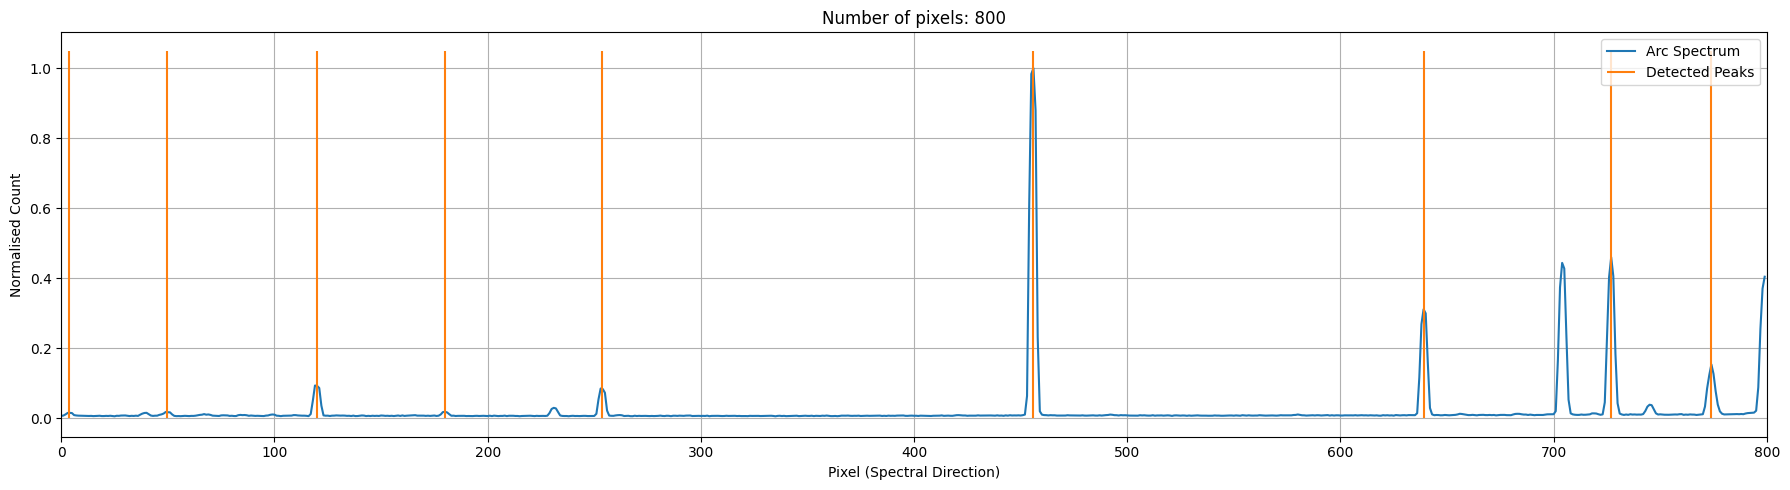

[Thu, 14 Dec 2023 10:32:55] WARNING [calibrator.py:1299] Using add_atlas is now deprecated. Please use the new Atlas class.


  0%|          | 0/200 [00:00<?, ?it/s]

[Thu, 14 Dec 2023 10:33:10] INFO [calibrator.py:750] Found: 9
[Thu, 14 Dec 2023 10:33:10] INFO [plotting.py:805] Peak at: 3187.6944690003775 A
[Thu, 14 Dec 2023 10:33:10] INFO [plotting.py:809] - matched to 3187.6944690003775 A
[Thu, 14 Dec 2023 10:33:10] INFO [plotting.py:805] Peak at: 3819.54772059857 A
[Thu, 14 Dec 2023 10:33:10] INFO [plotting.py:809] - matched to 3819.54772059857 A
[Thu, 14 Dec 2023 10:33:10] INFO [plotting.py:805] Peak at: 4200.609272956141 A
[Thu, 14 Dec 2023 10:33:10] INFO [plotting.py:809] - matched to 4200.609272956141 A
[Thu, 14 Dec 2023 10:33:10] INFO [plotting.py:805] Peak at: 4335.270927935971 A
[Thu, 14 Dec 2023 10:33:10] INFO [plotting.py:809] - matched to 4335.270927935971 A
[Thu, 14 Dec 2023 10:33:10] INFO [plotting.py:805] Peak at: 4596.026349801669 A
[Thu, 14 Dec 2023 10:33:10] INFO [plotting.py:809] - matched to 4596.026349801669 A
[Thu, 14 Dec 2023 10:33:10] INFO [plotting.py:805] Peak at: 6678.049494311709 A
[Thu, 14 Dec 2023 10:33:10] INFO [plot

RMS: 0.06442280977067327
Stdev error: 0.04678462523434211 A
Peaks utilisation rate: 100.0%


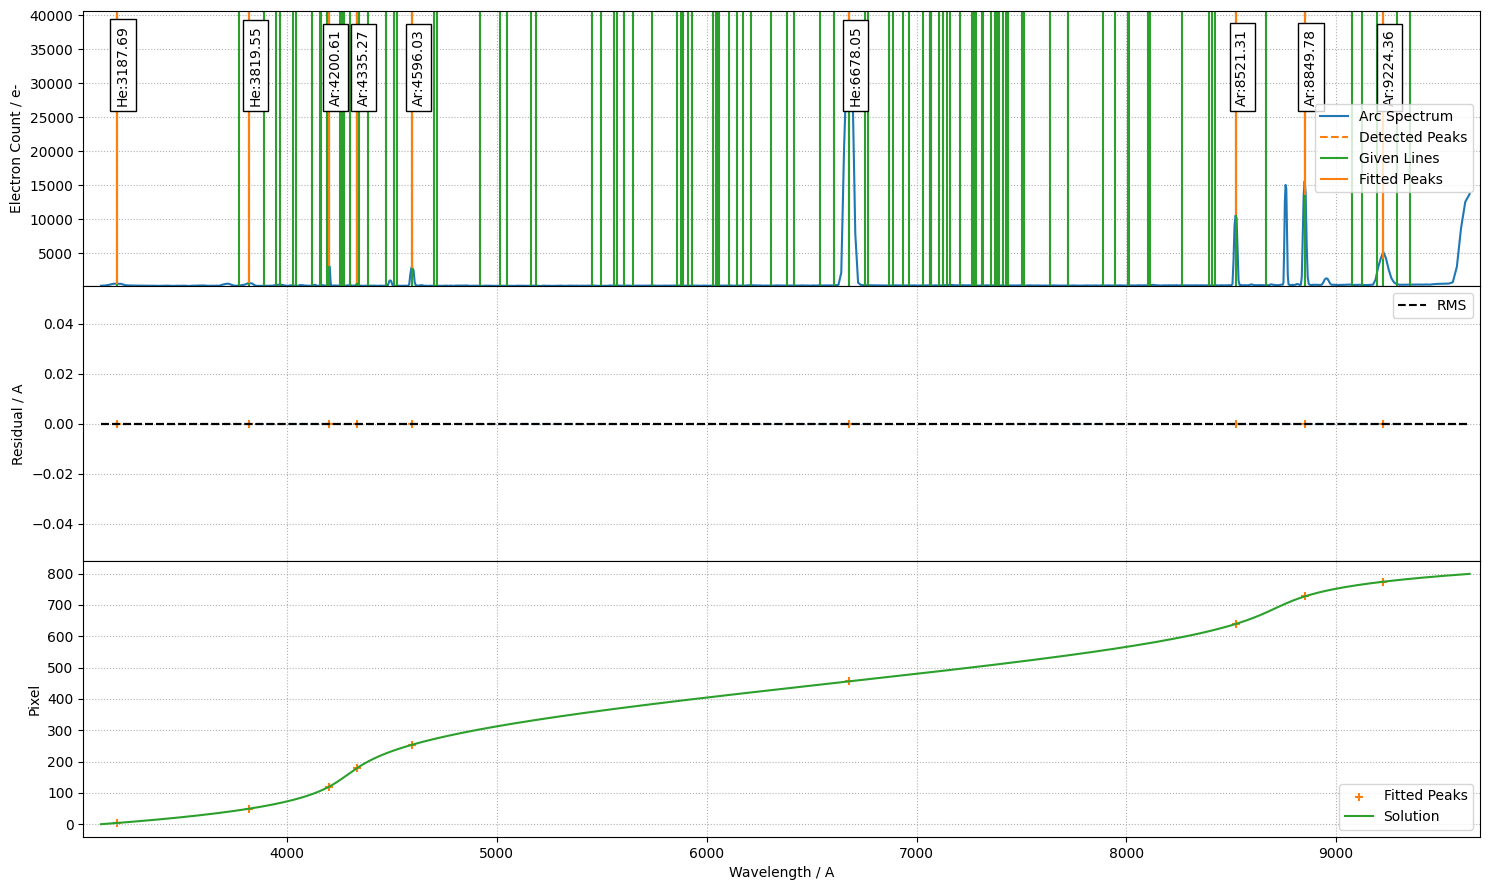

[ 3.11316269e+03  2.01084223e+01 -1.40243725e-01  4.83070557e-04
 -7.68227090e-07  8.60617813e-10 -8.70930371e-13  4.47506163e-16]
[0. 0. 0. 0. 0. 0. 0. 0.]


In [54]:
wvl1 = rascal_find_wvl_solution(spectrum_1, 3000, 9000)
wvl2 = rascal_find_wvl_solution(spectrum_2, 3000, 9000)

In [55]:
wvl1, wvl2

(array([2919.86224272, 2947.19875668, 2974.08094446, 3000.51418635,
        3026.50382791, 3052.05518005, 3077.17351917, 3101.86408714,
        3126.1320915 , 3149.98270548, 3173.42106811, 3196.4522843 ,
        3219.08142494, 3241.31352699, 3263.15359354, 3284.60659393,
        3305.67746383, 3326.37110534, 3346.69238704, 3366.64614415,
        3386.23717853, 3405.47025886, 3424.35012067, 3442.88146646,
        3461.06896576, 3478.91725527, 3496.43093892, 3513.61458794,
        3530.47274102, 3547.00990432, 3563.23055162, 3579.1391244 ,
        3594.74003193, 3610.03765133, 3625.03632774, 3639.74037432,
        3654.15407243, 3668.28167165, 3682.12738994, 3695.69541367,
        3708.98989778, 3722.01496581, 3734.77471003, 3747.27319156,
        3759.51444039, 3771.50245556, 3783.24120519, 3794.73462661,
        3805.98662644, 3817.00108071, 3827.78183492, 3838.33270416,
        3848.65747321, 3858.75989662, 3868.64369881, 3878.31257419,
        3887.77018721, 3897.02017252, 3906.06613

In [58]:
print(wvl2[0])
wvl1[0]
len(wvl1)

3113.162690490636


800

In [14]:
pickle.dump(wvl1,open(parent_direc+'/pickled_objects/arc_solution_trace1_rascal.pickle','wb'))
pickle.dump(wvl2,open(parent_direc+'/pickled_objects/arc_solution_trace2_rascal.pickle','wb'))